In [1]:
from dotenv import load_dotenv
load_dotenv()  

True

In [2]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model='text-embedding-3-large')

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name = 'income_tax_collection',
    persist_directory = './income_tax_collection'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

RAG : vector store + web 검색 (Tavily)

In [3]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list
    answer: str
    
graph_builder = StateGraph(AgentState)

In [4]:
def retrieve(state: AgentState) -> AgentState:
    query = state['query']
    docs = retriever.invoke(query)
    return {'context': docs}

In [5]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

In [6]:
from langchain_classic import hub
from langchain_core.callbacks import StreamingStdOutCallbackHandler
from langchain_core.output_parsers import StrOutputParser

generate_prompt = hub.pull("rlm/rag-prompt")

generate_llm = ChatOpenAI(model='gpt-4o', max_completion_tokens=100)

def generate(state: AgentState) -> AgentState:

    context = state['context']
    query = state['query']
    
    rag_chain = generate_prompt | generate_llm | StrOutputParser()
    
    response = rag_chain.invoke({'question': query, 'context': context})
    
    return {'answer': response}

In [7]:
# set the LANGCHAIN_API_KEY environment variable (create key in settings)
from langchain_classic import hub
from typing import Literal
doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['relevant', 'irrelvant']:

    query = state['query']
    context = state['context']

    doc_relevance_chain = doc_relevance_prompt | llm
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})

    if response['Score'] == 1:
        return 'relevant'
    
    return 'irrelvant'

In [8]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

rewrite_prompt = PromptTemplate.from_template("""사용자의 질문을 보고, 웹 검색에 용이하게 사용자의 질문을 수정해주세요
질문: {query}
""")

def rewrite(state: AgentState):
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    response = rewrite_chain.invoke({'query': query})

    return {'query': response}

In [9]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

def web_search(state: AgentState) -> AgentState:
    query = state['query']
    results = tavily_search_tool.invoke(query)
    return {'context': results}

/var/folders/rb/wylmzgk90lb3vbd81tm_qck00000gn/T/ipykernel_26077/3989946988.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily_search_tool = TavilySearchResults(


In [10]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
# graph_builder.add_node('rewrite', rewrite)
graph_builder.add_node('web_search', web_search)

서비스 관점에서 굳이 rewrite는 필요 없다. 

In [11]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges(
    'retrieve',
    check_doc_relevance,
    {
        'relevant': 'generate',
        'irrelvant': 'web_search'
    }
)
# graph_builder.add_edge('rewrite', 'web_search')
graph_builder.add_edge('web_search', 'generate')
graph_builder.add_edge('generate', END)

In [12]:
graph = graph_builder.compile()

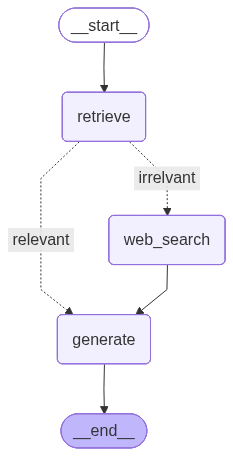

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
initial_state = {'query': '연봉 5천만원 거주자의 소득세는 얼마인가요?'}
graph.invoke(initial_state)

{'query': '연봉 5천만원 거주자의 소득세는 얼마인가요?',
 'context': [{'title': '2025 연봉 실수령액표 연봉계산기 (연봉 3000 5000 6000 8000 ...',
   'url': 'https://m.blog.naver.com/subjun85/223824595382?recommendCode=2&recommendTrackingCode=2',
   'content': "\u200b\n\n▶ 연봉 3000 실수령액\n\n연봉 3천만원의 경우, 4대보험과 세금을 제외하면 연봉 실 수령액은 27,019,800원으로 계산됩니다. 월 수령액으로 보면 약 225만원 정도로 나오네요. 세금을 포함해 공제되는 금액이 연봉의 10% 정도입니다.\n\n\u200b\n\n▶ 연봉 5000 실수령액\n\n연봉 5천만원의 경우, 4대보험과 세금을 제외하면 연봉 실 수령액은 43,007,720원으로 계산됩니다. 월 수령액으로 보면 약 358만원 정도입니다. 세금을 포함해 공제되는 금액이 연봉의 약 14%로 올라갑니다.\n\n\u200b\n\n▶ 연봉 6000 실수령액\n\n연봉 6천만원의 경우, 4대보험과 세금을 제외하면 연봉 실 수령액은 50,525,400원으로 계산됩니다. 월 수령액으로 보면 약 421만원 정도입니다. 세금을 포함한 공제되는 금액이 연봉의 10% 정도입니다. 세금을 포함해 공제되는 금액이 연봉의 약 16% 정도입니다.\n\n\u200b\n\n▶ 연봉 8000 실수령액\n\n연봉 8천만원의 경우, 4대보험과 세금을 제외하면 연봉 실 수령액은 64,807,760원으로 계산됩니다. 월 수령액으로 보면 약 540만원 정도입니다. 세금을 포함해 공제되는 금액이 연봉의 약 19%로 더 올라갑니다.\n\n\u200b\n\n▶ 연봉 9000 월 실수령액\n\n연봉 9천만원의 경우, 4대보험과 세금을 제외하면 연봉 실 수령액은 71,802,600원으로 계산됩니다. 월 수령액으로 보면 약 598만원 정도입니다. 세금을 포함해 공제되는 금액이 연봉의 

In [15]:
initial_state = {'query': '역삼역 맛집을 추천해주세요'}
graph.invoke(initial_state)

{'query': '역삼역 맛집을 추천해주세요',
 'context': [{'title': '[역삼역 맛집 ] 요즘 뜨겁게 핫한 역삼역 맛집 Top 8 - 지니의 솔까 리뷰',
   'url': 'https://jspringlife.com/entry/%EC%97%AD%EC%82%BC%EC%97%AD-%EB%A7%9B%EC%A7%91-%F0%9F%92%96-%EC%9A%94%EC%A6%98-%EB%9C%A8%EA%B2%81%EA%B2%8C-%ED%95%AB%ED%95%9C-%EC%97%AD%EC%82%BC%EC%97%AD-%EB%A7%9B%EC%A7%91-Top-8-%F0%9F%98%8E%F0%9F%94%A5',
   'content': '| [[수원역 맛집 💖] 요즘 뜨겁게 핫한 숨은 수원역 맛집 Top 8 😎🔥](/entry/%EC%88%98%EC%9B%90%EC%97%AD-%EB%A7%9B%EC%A7%91-%F0%9F%92%96-%EC%9A%94%EC%A6%98-%EB%9C%A8%EA%B2%81%EA%B2%8C-%ED%95%AB%ED%95%9C-%EC%88%A8%EC%9D%80-%EC%88%98%EC%9B%90%EC%97%AD-%EB%A7%9B%EC%A7%91-Top-8-%F0%9F%98%8E%F0%9F%94%A5)  (0) | 2023.01.29 | [...] [[교대역 맛집 💖] 요즘 뜨겁게 핫한 교대역 맛집 Top 8 😎🔥](/entry/%EA%B5%90%EB%8C%80%EC%97%AD-%EB%A7%9B%EC%A7%91-%F0%9F%92%96-%EC%9A%94%EC%A6%98-%EB%9C%A8%EA%B2%81%EA%B2%8C-%ED%95%AB%ED%95%9C-%EA%B5%90%EB%8C%80%EC%97%AD-%EB%A7%9B%EC%A7%91-Top-8-%F0%9F%98%8E%F0%9F%94%A5?category=1103549)\n [[강남 맛집 💖] 요즘 뜨겁게 핫한 숨은 강남 맛집 Top 8 😎🔥](/entry/%EA%B0%95%EB%82%A8-%E